In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                                                                             | 0/60000 [00:00<?, ?it/s]

 12%|█████████████████                                                                                                                              | 7169/60000 [00:00<00:00, 71680.84it/s]

 24%|█████████████████████████████████▉                                                                                                            | 14362/60000 [00:00<00:00, 71824.31it/s]

 36%|███████████████████████████████████████████████████▎                                                                                          | 21688/60000 [00:00<00:00, 72476.17it/s]

 48%|████████████████████████████████████████████████████████████████████▍                                                                         | 28936/60000 [00:00<00:00, 71818.99it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 36330/60000 [00:00<00:00, 72575.35it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 43698/60000 [00:00<00:00, 72949.01it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 50994/60000 [00:00<00:00, 71825.56it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 58249/60000 [00:00<00:00, 72051.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 71895.51it/s]

  0%|                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7168/10000 [00:00<00:00, 71676.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 71311.81it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 dqkmlnla


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                               | 0/375 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                      | 1/375 [00:00<03:54,  1.59it/s]

  1%|█▏                                                                                                                                                     | 3/375 [00:00<01:15,  4.94it/s]

  1%|██                                                                                                                                                     | 5/375 [00:00<00:46,  7.95it/s]

  2%|██▊                                                                                                                                                    | 7/375 [00:00<00:34, 10.52it/s]

  2%|███▌                                                                                                                                                   | 9/375 [00:01<00:29, 12.61it/s]

  3%|████▍                                                                                                                                                 | 11/375 [00:01<00:25, 14.21it/s]

  3%|█████▏                                                                                                                                                | 13/375 [00:01<00:23, 15.42it/s]

  4%|██████                                                                                                                                                | 15/375 [00:01<00:22, 16.31it/s]

  5%|██████▊                                                                                                                                               | 17/375 [00:01<00:21, 16.96it/s]

  5%|███████▌                                                                                                                                              | 19/375 [00:01<00:20, 17.42it/s]

  6%|████████▍                                                                                                                                             | 21/375 [00:01<00:19, 17.75it/s]

  6%|█████████▏                                                                                                                                            | 23/375 [00:01<00:19, 17.98it/s]

  7%|██████████                                                                                                                                            | 25/375 [00:01<00:19, 18.15it/s]

  7%|██████████▊                                                                                                                                           | 27/375 [00:02<00:19, 18.27it/s]

  8%|███████████▌                                                                                                                                          | 29/375 [00:02<00:18, 18.33it/s]

  8%|████████████▍                                                                                                                                         | 31/375 [00:02<00:18, 18.40it/s]

  9%|█████████████▏                                                                                                                                        | 33/375 [00:02<00:18, 18.45it/s]

  9%|██████████████                                                                                                                                        | 35/375 [00:02<00:18, 18.49it/s]

 10%|██████████████▊                                                                                                                                       | 37/375 [00:02<00:18, 18.51it/s]

 10%|███████████████▌                                                                                                                                      | 39/375 [00:02<00:18, 18.53it/s]

 11%|████████████████▍                                                                                                                                     | 41/375 [00:02<00:18, 18.55it/s]

 11%|█████████████████▏                                                                                                                                    | 43/375 [00:02<00:17, 18.55it/s]

 12%|██████████████████                                                                                                                                    | 45/375 [00:02<00:17, 18.56it/s]

 13%|██████████████████▊                                                                                                                                   | 47/375 [00:03<00:17, 18.57it/s]

 13%|███████████████████▌                                                                                                                                  | 49/375 [00:03<00:17, 18.57it/s]

 14%|████████████████████▍                                                                                                                                 | 51/375 [00:03<00:17, 18.58it/s]

 14%|█████████████████████▏                                                                                                                                | 53/375 [00:03<00:17, 18.58it/s]

 15%|██████████████████████                                                                                                                                | 55/375 [00:03<00:17, 18.59it/s]

 15%|██████████████████████▊                                                                                                                               | 57/375 [00:03<00:17, 18.46it/s]

 16%|███████████████████████▌                                                                                                                              | 59/375 [00:03<00:17, 18.48it/s]

 16%|████████████████████████▍                                                                                                                             | 61/375 [00:03<00:16, 18.51it/s]

 17%|█████████████████████████▏                                                                                                                            | 63/375 [00:03<00:16, 18.53it/s]

 17%|██████████████████████████                                                                                                                            | 65/375 [00:04<00:16, 18.53it/s]

 18%|██████████████████████████▊                                                                                                                           | 67/375 [00:04<00:16, 18.55it/s]

 18%|███████████████████████████▌                                                                                                                          | 69/375 [00:04<00:16, 18.56it/s]

 19%|████████████████████████████▍                                                                                                                         | 71/375 [00:04<00:16, 18.56it/s]

 19%|█████████████████████████████▏                                                                                                                        | 73/375 [00:04<00:16, 18.56it/s]

 20%|██████████████████████████████                                                                                                                        | 75/375 [00:04<00:16, 18.57it/s]

 21%|██████████████████████████████▊                                                                                                                       | 77/375 [00:04<00:16, 18.58it/s]

 21%|███████████████████████████████▌                                                                                                                      | 79/375 [00:04<00:15, 18.59it/s]

 22%|████████████████████████████████▍                                                                                                                     | 81/375 [00:04<00:15, 18.59it/s]

 22%|█████████████████████████████████▏                                                                                                                    | 83/375 [00:05<00:15, 18.57it/s]

 23%|██████████████████████████████████                                                                                                                    | 85/375 [00:05<00:15, 18.58it/s]

 23%|██████████████████████████████████▊                                                                                                                   | 87/375 [00:05<00:15, 18.59it/s]

 24%|███████████████████████████████████▌                                                                                                                  | 89/375 [00:05<00:15, 18.59it/s]

 24%|████████████████████████████████████▍                                                                                                                 | 91/375 [00:05<00:15, 18.59it/s]

 25%|█████████████████████████████████████▏                                                                                                                | 93/375 [00:05<00:15, 18.58it/s]

 25%|██████████████████████████████████████                                                                                                                | 95/375 [00:05<00:15, 18.56it/s]

 26%|██████████████████████████████████████▊                                                                                                               | 97/375 [00:05<00:14, 18.56it/s]

 26%|███████████████████████████████████████▌                                                                                                              | 99/375 [00:05<00:14, 18.56it/s]

 27%|████████████████████████████████████████▏                                                                                                            | 101/375 [00:06<00:14, 18.56it/s]

 27%|████████████████████████████████████████▉                                                                                                            | 103/375 [00:06<00:14, 18.57it/s]

 28%|█████████████████████████████████████████▋                                                                                                           | 105/375 [00:06<00:14, 18.56it/s]

 29%|██████████████████████████████████████████▌                                                                                                          | 107/375 [00:06<00:14, 18.55it/s]

 29%|███████████████████████████████████████████▎                                                                                                         | 109/375 [00:06<00:14, 18.57it/s]

 30%|████████████████████████████████████████████                                                                                                         | 111/375 [00:06<00:14, 18.57it/s]

 30%|████████████████████████████████████████████▉                                                                                                        | 113/375 [00:06<00:14, 18.57it/s]

 31%|█████████████████████████████████████████████▋                                                                                                       | 115/375 [00:06<00:13, 18.57it/s]

 31%|██████████████████████████████████████████████▍                                                                                                      | 117/375 [00:06<00:13, 18.58it/s]

 32%|███████████████████████████████████████████████▎                                                                                                     | 119/375 [00:06<00:13, 18.59it/s]

 32%|████████████████████████████████████████████████                                                                                                     | 121/375 [00:07<00:13, 18.58it/s]

 33%|████████████████████████████████████████████████▊                                                                                                    | 123/375 [00:07<00:13, 18.58it/s]

 33%|█████████████████████████████████████████████████▋                                                                                                   | 125/375 [00:07<00:13, 18.59it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                  | 127/375 [00:07<00:13, 18.59it/s]

 34%|███████████████████████████████████████████████████▎                                                                                                 | 129/375 [00:07<00:13, 18.59it/s]

 35%|████████████████████████████████████████████████████                                                                                                 | 131/375 [00:07<00:13, 18.59it/s]

 35%|████████████████████████████████████████████████████▊                                                                                                | 133/375 [00:07<00:13, 18.59it/s]

 36%|█████████████████████████████████████████████████████▋                                                                                               | 135/375 [00:07<00:12, 18.60it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                              | 137/375 [00:07<00:12, 18.55it/s]

 37%|███████████████████████████████████████████████████████▏                                                                                             | 139/375 [00:08<00:12, 18.56it/s]

 38%|████████████████████████████████████████████████████████                                                                                             | 141/375 [00:08<00:12, 18.57it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                            | 143/375 [00:08<00:12, 18.58it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                           | 145/375 [00:08<00:12, 18.58it/s]

 39%|██████████████████████████████████████████████████████████▍                                                                                          | 147/375 [00:08<00:12, 18.58it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                         | 149/375 [00:08<00:12, 18.58it/s]

 40%|███████████████████████████████████████████████████████████▉                                                                                         | 151/375 [00:08<00:12, 18.58it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                        | 153/375 [00:08<00:11, 18.58it/s]

 41%|█████████████████████████████████████████████████████████████▌                                                                                       | 155/375 [00:08<00:11, 18.58it/s]

 42%|██████████████████████████████████████████████████████████████▍                                                                                      | 157/375 [00:09<00:11, 18.58it/s]

 42%|███████████████████████████████████████████████████████████████▏                                                                                     | 159/375 [00:09<00:11, 18.57it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                     | 161/375 [00:09<00:11, 18.57it/s]

 43%|████████████████████████████████████████████████████████████████▊                                                                                    | 163/375 [00:09<00:11, 18.58it/s]

 44%|█████████████████████████████████████████████████████████████████▌                                                                                   | 165/375 [00:09<00:11, 18.57it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                                  | 167/375 [00:09<00:11, 18.57it/s]

 45%|███████████████████████████████████████████████████████████████████▏                                                                                 | 169/375 [00:09<00:11, 18.57it/s]

 46%|███████████████████████████████████████████████████████████████████▉                                                                                 | 171/375 [00:09<00:10, 18.56it/s]

 46%|████████████████████████████████████████████████████████████████████▋                                                                                | 173/375 [00:09<00:10, 18.56it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                               | 175/375 [00:09<00:10, 18.54it/s]

 47%|██████████████████████████████████████████████████████████████████████▎                                                                              | 177/375 [00:10<00:10, 18.56it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                              | 179/375 [00:10<00:10, 18.57it/s]

 48%|███████████████████████████████████████████████████████████████████████▉                                                                             | 181/375 [00:10<00:10, 18.58it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                            | 183/375 [00:10<00:10, 18.58it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                           | 185/375 [00:10<00:10, 18.58it/s]

 50%|██████████████████████████████████████████████████████████████████████████▎                                                                          | 187/375 [00:10<00:10, 18.59it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                          | 189/375 [00:10<00:10, 18.59it/s]

 51%|███████████████████████████████████████████████████████████████████████████▉                                                                         | 191/375 [00:10<00:09, 18.58it/s]

 51%|████████████████████████████████████████████████████████████████████████████▋                                                                        | 193/375 [00:10<00:09, 18.58it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▍                                                                       | 195/375 [00:11<00:09, 18.58it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                      | 197/375 [00:11<00:09, 18.54it/s]

 53%|███████████████████████████████████████████████████████████████████████████████                                                                      | 199/375 [00:11<00:09, 18.53it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                     | 201/375 [00:11<00:09, 18.55it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▋                                                                    | 203/375 [00:11<00:09, 18.56it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                   | 205/375 [00:11<00:09, 18.57it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▏                                                                  | 207/375 [00:11<00:09, 18.57it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████                                                                  | 209/375 [00:11<00:08, 18.58it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                 | 211/375 [00:11<00:08, 18.58it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▋                                                                | 213/375 [00:12<00:08, 18.58it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                               | 215/375 [00:12<00:08, 18.59it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▏                                                              | 217/375 [00:12<00:08, 18.59it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████                                                              | 219/375 [00:12<00:08, 18.59it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▊                                                             | 221/375 [00:12<00:08, 18.58it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 223/375 [00:12<00:08, 18.59it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 225/375 [00:12<00:08, 18.59it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 227/375 [00:12<00:07, 18.59it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 229/375 [00:12<00:07, 18.59it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 231/375 [00:13<00:07, 18.51it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 233/375 [00:13<00:07, 18.51it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 235/375 [00:13<00:07, 18.53it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 237/375 [00:13<00:07, 18.55it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 239/375 [00:13<00:07, 18.56it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 241/375 [00:13<00:07, 18.56it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 243/375 [00:13<00:07, 18.56it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 245/375 [00:13<00:07, 18.56it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 247/375 [00:13<00:06, 18.56it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 249/375 [00:13<00:06, 18.55it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 251/375 [00:14<00:06, 18.57it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 253/375 [00:14<00:06, 18.57it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 255/375 [00:14<00:06, 18.59it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 257/375 [00:14<00:06, 18.59it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 259/375 [00:14<00:06, 18.59it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 261/375 [00:14<00:06, 18.59it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 263/375 [00:14<00:06, 18.57it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 265/375 [00:14<00:05, 18.57it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 267/375 [00:14<00:05, 18.58it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 269/375 [00:15<00:05, 18.58it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 271/375 [00:15<00:05, 18.58it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 273/375 [00:15<00:05, 18.59it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 275/375 [00:15<00:05, 18.58it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 277/375 [00:15<00:05, 18.58it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 279/375 [00:15<00:05, 18.59it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 281/375 [00:15<00:05, 18.56it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 283/375 [00:15<00:04, 18.59it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 285/375 [00:15<00:04, 18.59it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 287/375 [00:16<00:04, 18.59it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 289/375 [00:16<00:04, 18.59it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 291/375 [00:16<00:04, 18.59it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 293/375 [00:16<00:04, 18.59it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 295/375 [00:16<00:04, 18.59it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 297/375 [00:16<00:04, 18.58it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 299/375 [00:16<00:04, 18.58it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 301/375 [00:16<00:03, 18.58it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 303/375 [00:16<00:03, 18.58it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 305/375 [00:16<00:03, 18.58it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 307/375 [00:17<00:03, 18.57it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 309/375 [00:17<00:03, 18.58it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 311/375 [00:17<00:03, 18.57it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 313/375 [00:17<00:03, 18.58it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 315/375 [00:17<00:03, 18.58it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 317/375 [00:17<00:03, 18.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 319/375 [00:17<00:03, 18.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 321/375 [00:17<00:02, 18.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 323/375 [00:17<00:02, 18.56it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 325/375 [00:18<00:02, 18.57it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 327/375 [00:18<00:02, 18.59it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 329/375 [00:18<00:02, 18.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 331/375 [00:18<00:02, 18.56it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 333/375 [00:18<00:02, 18.57it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 335/375 [00:18<00:02, 18.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 337/375 [00:18<00:02, 18.58it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 339/375 [00:18<00:01, 18.58it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 341/375 [00:18<00:01, 18.59it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 343/375 [00:19<00:01, 18.59it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 345/375 [00:19<00:01, 18.58it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 347/375 [00:19<00:01, 18.58it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 349/375 [00:19<00:01, 18.59it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 351/375 [00:19<00:01, 18.59it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 353/375 [00:19<00:01, 18.58it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 355/375 [00:19<00:01, 18.58it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 357/375 [00:19<00:00, 18.56it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 359/375 [00:19<00:00, 18.58it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 361/375 [00:20<00:00, 18.52it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 363/375 [00:20<00:00, 18.54it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 365/375 [00:20<00:00, 18.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 367/375 [00:20<00:00, 18.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 369/375 [00:20<00:00, 18.49it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 371/375 [00:20<00:00, 18.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 373/375 [00:20<00:00, 18.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:20<00:00, 18.58it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:20<00:00, 18.05it/s]

train - OK


  0%|                                                                                                                                                                | 0/94 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                                      | 1/94 [00:00<00:12,  7.37it/s]

  3%|████▊                                                                                                                                                   | 3/94 [00:00<00:06, 13.27it/s]

  5%|████████                                                                                                                                                | 5/94 [00:00<00:05, 15.56it/s]

  7%|███████████▎                                                                                                                                            | 7/94 [00:00<00:05, 16.73it/s]

 10%|██████████████▌                                                                                                                                         | 9/94 [00:00<00:04, 17.38it/s]

 12%|█████████████████▋                                                                                                                                     | 11/94 [00:00<00:04, 17.80it/s]

 14%|████████████████████▉                                                                                                                                  | 13/94 [00:00<00:04, 18.06it/s]

 16%|████████████████████████                                                                                                                               | 15/94 [00:00<00:04, 18.23it/s]

 18%|███████████████████████████▎                                                                                                                           | 17/94 [00:00<00:04, 18.34it/s]

 20%|██████████████████████████████▌                                                                                                                        | 19/94 [00:01<00:04, 18.43it/s]

 22%|█████████████████████████████████▋                                                                                                                     | 21/94 [00:01<00:03, 18.48it/s]

 24%|████████████████████████████████████▉                                                                                                                  | 23/94 [00:01<00:03, 18.53it/s]

 27%|████████████████████████████████████████▏                                                                                                              | 25/94 [00:01<00:03, 18.49it/s]

 29%|███████████████████████████████████████████▎                                                                                                           | 27/94 [00:01<00:03, 18.54it/s]

 31%|██████████████████████████████████████████████▌                                                                                                        | 29/94 [00:01<00:03, 18.57it/s]

 33%|█████████████████████████████████████████████████▊                                                                                                     | 31/94 [00:01<00:03, 18.59it/s]

 35%|█████████████████████████████████████████████████████                                                                                                  | 33/94 [00:01<00:03, 18.59it/s]

 37%|████████████████████████████████████████████████████████▏                                                                                              | 35/94 [00:01<00:03, 18.59it/s]

 39%|███████████████████████████████████████████████████████████▍                                                                                           | 37/94 [00:02<00:03, 18.60it/s]

 41%|██████████████████████████████████████████████████████████████▋                                                                                        | 39/94 [00:02<00:02, 18.60it/s]

 44%|█████████████████████████████████████████████████████████████████▊                                                                                     | 41/94 [00:02<00:02, 18.61it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                  | 43/94 [00:02<00:02, 18.61it/s]

 48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 45/94 [00:02<00:02, 18.61it/s]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 47/94 [00:02<00:02, 18.61it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 49/94 [00:02<00:02, 18.60it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▉                                                                     | 51/94 [00:02<00:02, 18.60it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 53/94 [00:02<00:02, 18.61it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 55/94 [00:03<00:02, 18.62it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 57/94 [00:03<00:01, 18.61it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 59/94 [00:03<00:01, 18.62it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 61/94 [00:03<00:01, 18.63it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 63/94 [00:03<00:01, 18.59it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 65/94 [00:03<00:01, 18.56it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 67/94 [00:03<00:01, 18.57it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 69/94 [00:03<00:01, 18.58it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 71/94 [00:03<00:01, 18.59it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 73/94 [00:04<00:01, 18.58it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 75/94 [00:04<00:01, 18.60it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 77/94 [00:04<00:00, 18.60it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 79/94 [00:04<00:00, 18.60it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 81/94 [00:04<00:00, 18.60it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 83/94 [00:04<00:00, 18.59it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 85/94 [00:04<00:00, 18.59it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 87/94 [00:04<00:00, 18.61it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 89/94 [00:04<00:00, 18.64it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 91/94 [00:04<00:00, 18.66it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 93/94 [00:05<00:00, 18.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.14it/s]

val - OK


  0%|                                                                                                                                                                | 0/79 [00:00<?, ?it/s]

  1%|█▉                                                                                                                                                      | 1/79 [00:00<00:10,  7.36it/s]

  4%|█████▊                                                                                                                                                  | 3/79 [00:00<00:05, 13.22it/s]

  6%|█████████▌                                                                                                                                              | 5/79 [00:00<00:04, 15.52it/s]

  9%|█████████████▍                                                                                                                                          | 7/79 [00:00<00:04, 16.64it/s]

 11%|█████████████████▎                                                                                                                                      | 9/79 [00:00<00:04, 17.31it/s]

 14%|█████████████████████                                                                                                                                  | 11/79 [00:00<00:03, 17.72it/s]

 16%|████████████████████████▊                                                                                                                              | 13/79 [00:00<00:03, 18.00it/s]

 19%|████████████████████████████▋                                                                                                                          | 15/79 [00:00<00:03, 18.18it/s]

 22%|████████████████████████████████▍                                                                                                                      | 17/79 [00:00<00:03, 18.31it/s]

 24%|████████████████████████████████████▎                                                                                                                  | 19/79 [00:01<00:03, 18.38it/s]

 27%|████████████████████████████████████████▏                                                                                                              | 21/79 [00:01<00:03, 18.45it/s]

 29%|███████████████████████████████████████████▉                                                                                                           | 23/79 [00:01<00:03, 18.49it/s]

 32%|███████████████████████████████████████████████▊                                                                                                       | 25/79 [00:01<00:02, 18.52it/s]

 34%|███████████████████████████████████████████████████▌                                                                                                   | 27/79 [00:01<00:02, 18.54it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                               | 29/79 [00:01<00:02, 18.56it/s]

 39%|███████████████████████████████████████████████████████████▎                                                                                           | 31/79 [00:01<00:02, 18.57it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                        | 33/79 [00:01<00:02, 18.58it/s]

 44%|██████████████████████████████████████████████████████████████████▉                                                                                    | 35/79 [00:01<00:02, 18.59it/s]

 47%|██████████████████████████████████████████████████████████████████████▋                                                                                | 37/79 [00:02<00:02, 18.57it/s]

 49%|██████████████████████████████████████████████████████████████████████████▌                                                                            | 39/79 [00:02<00:02, 18.57it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 41/79 [00:02<00:02, 18.58it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 43/79 [00:02<00:01, 18.59it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 45/79 [00:02<00:01, 18.60it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 47/79 [00:02<00:01, 18.59it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 49/79 [00:02<00:01, 18.63it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 51/79 [00:02<00:01, 18.63it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 53/79 [00:02<00:01, 18.62it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 55/79 [00:03<00:01, 18.61it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 57/79 [00:03<00:01, 18.61it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 59/79 [00:03<00:01, 18.61it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 61/79 [00:03<00:00, 18.62it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 63/79 [00:03<00:00, 18.65it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 65/79 [00:03<00:00, 18.64it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 67/79 [00:03<00:00, 18.64it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 69/79 [00:03<00:00, 18.63it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 71/79 [00:03<00:00, 18.63it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 73/79 [00:04<00:00, 18.64it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75/79 [00:04<00:00, 18.66it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77/79 [00:04<00:00, 18.65it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.15it/s]

test InD - OK


  0%|                                                                                                                                                               | 0/100 [00:00<?, ?it/s]

  3%|████▌                                                                                                                                                  | 3/100 [00:00<00:04, 21.82it/s]

  6%|█████████                                                                                                                                              | 6/100 [00:00<00:04, 21.85it/s]

  9%|█████████████▌                                                                                                                                         | 9/100 [00:00<00:04, 21.87it/s]

 12%|██████████████████                                                                                                                                    | 12/100 [00:00<00:04, 21.88it/s]

 15%|██████████████████████▌                                                                                                                               | 15/100 [00:00<00:03, 21.88it/s]

 18%|███████████████████████████                                                                                                                           | 18/100 [00:00<00:03, 21.89it/s]

 21%|███████████████████████████████▌                                                                                                                      | 21/100 [00:00<00:03, 21.89it/s]

 24%|████████████████████████████████████                                                                                                                  | 24/100 [00:01<00:03, 21.89it/s]

 27%|████████████████████████████████████████▌                                                                                                             | 27/100 [00:01<00:03, 21.88it/s]

 30%|█████████████████████████████████████████████                                                                                                         | 30/100 [00:01<00:03, 21.87it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                    | 33/100 [00:01<00:03, 21.88it/s]

 36%|██████████████████████████████████████████████████████                                                                                                | 36/100 [00:01<00:02, 21.88it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                           | 39/100 [00:01<00:02, 21.88it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                       | 42/100 [00:01<00:02, 21.89it/s]

 45%|███████████████████████████████████████████████████████████████████▌                                                                                  | 45/100 [00:02<00:02, 21.89it/s]

 48%|████████████████████████████████████████████████████████████████████████                                                                              | 48/100 [00:02<00:02, 21.89it/s]

 51%|████████████████████████████████████████████████████████████████████████████▌                                                                         | 51/100 [00:02<00:02, 21.89it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                     | 54/100 [00:02<00:02, 21.89it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                | 57/100 [00:02<00:01, 21.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                            | 60/100 [00:02<00:01, 21.90it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 63/100 [00:02<00:01, 21.90it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 66/100 [00:03<00:01, 21.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 69/100 [00:03<00:01, 21.90it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 72/100 [00:03<00:01, 21.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 75/100 [00:03<00:01, 21.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 78/100 [00:03<00:01, 21.89it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 81/100 [00:03<00:00, 21.90it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 84/100 [00:03<00:00, 21.89it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 87/100 [00:03<00:00, 21.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 90/100 [00:04<00:00, 21.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 93/100 [00:04<00:00, 21.90it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:04<00:00, 21.89it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:04<00:00, 21.89it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.89it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(48000, 1, 32, 32) (48000, 256) (48000, 768) (48000, 1, 32, 32) (48000,)
(12000, 1, 32, 32) (12000, 256) (12000, 768) (12000, 1, 32, 32) (12000,)
(10000, 1, 32, 32) (10000, 256) (10000, 768) (10000, 1, 32, 32) (10000,)
(12800, 1, 32, 32) (12800, 256) (12800, 768) (12800, 1, 32, 32)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10000, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10000, 2) (0, 2)


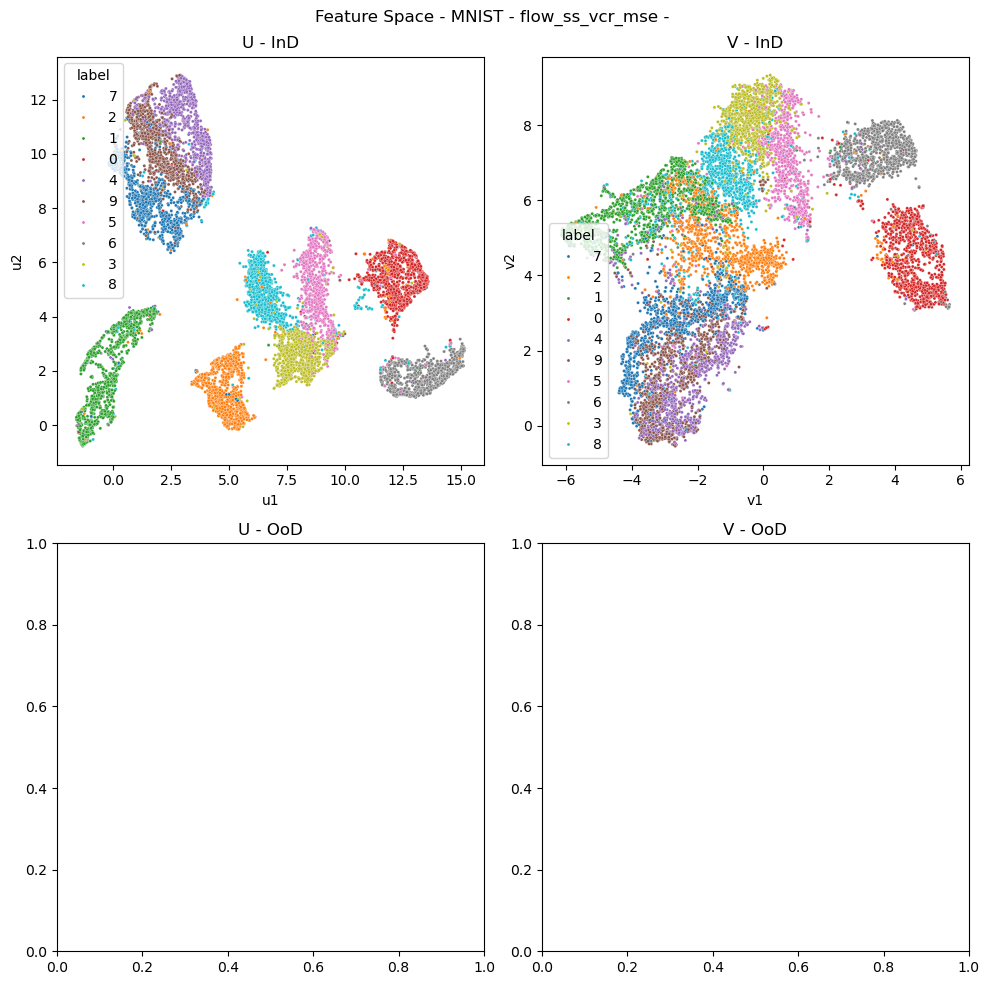

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

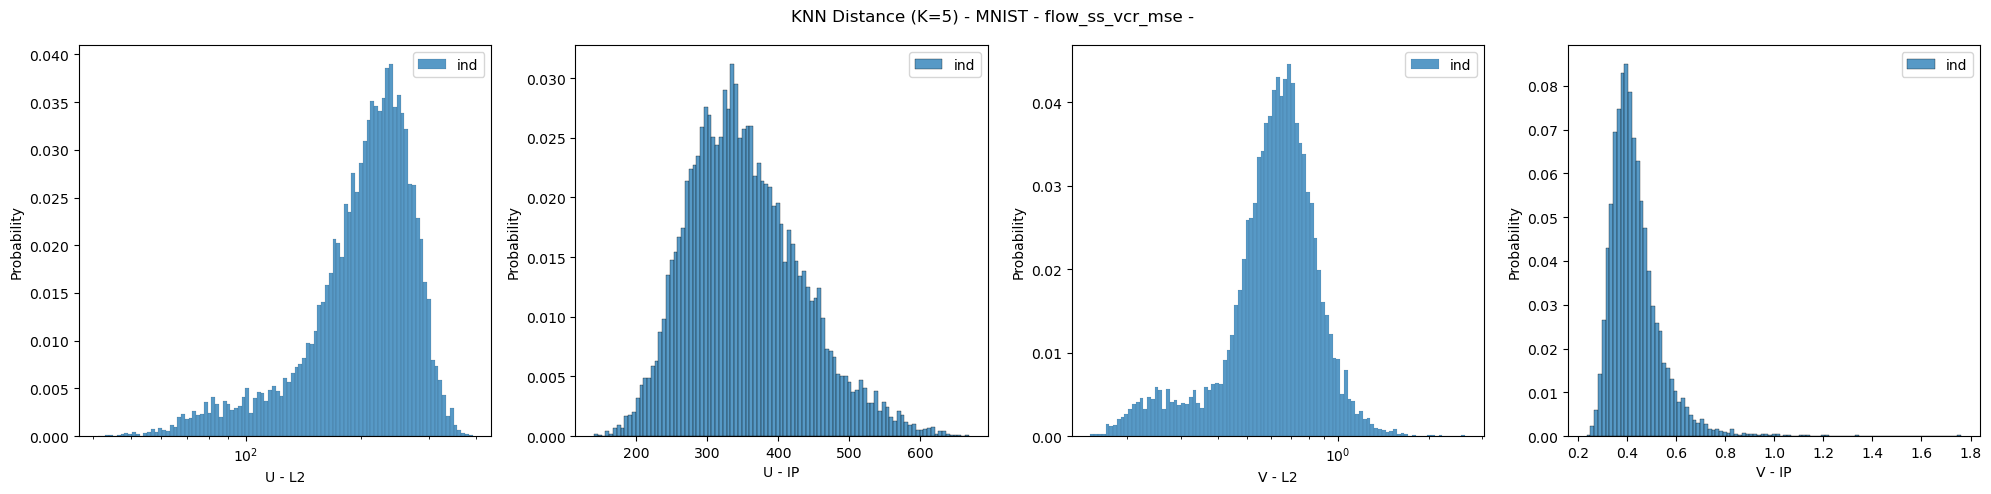

In [13]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[1], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[2], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[3], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

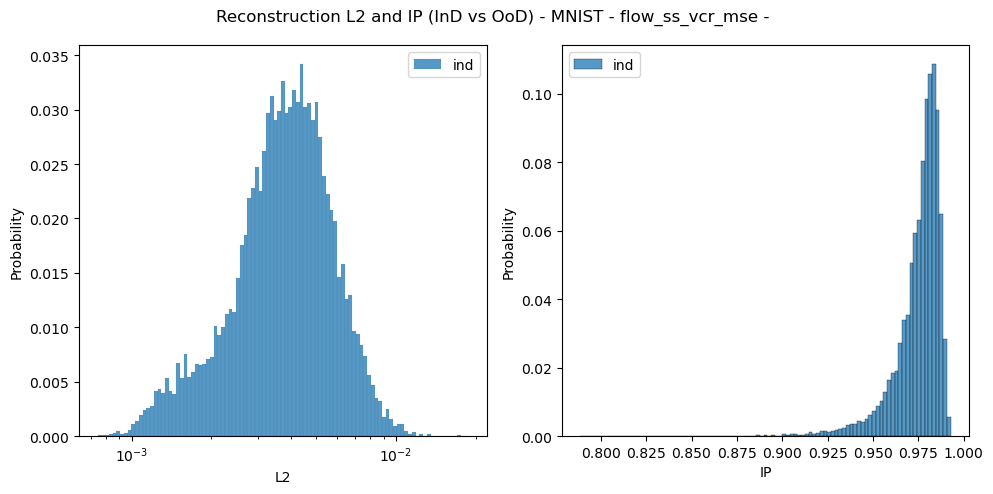

In [14]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_inp.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_inp.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

20.764482 2.0695543 0.8649212 0.11527661
20.711119 2.0546055 0.86724406 0.116387755
20.851507 2.0569322 0.86075896 0.111787155
34.58174 2.1397343 26.551538 0.8020254


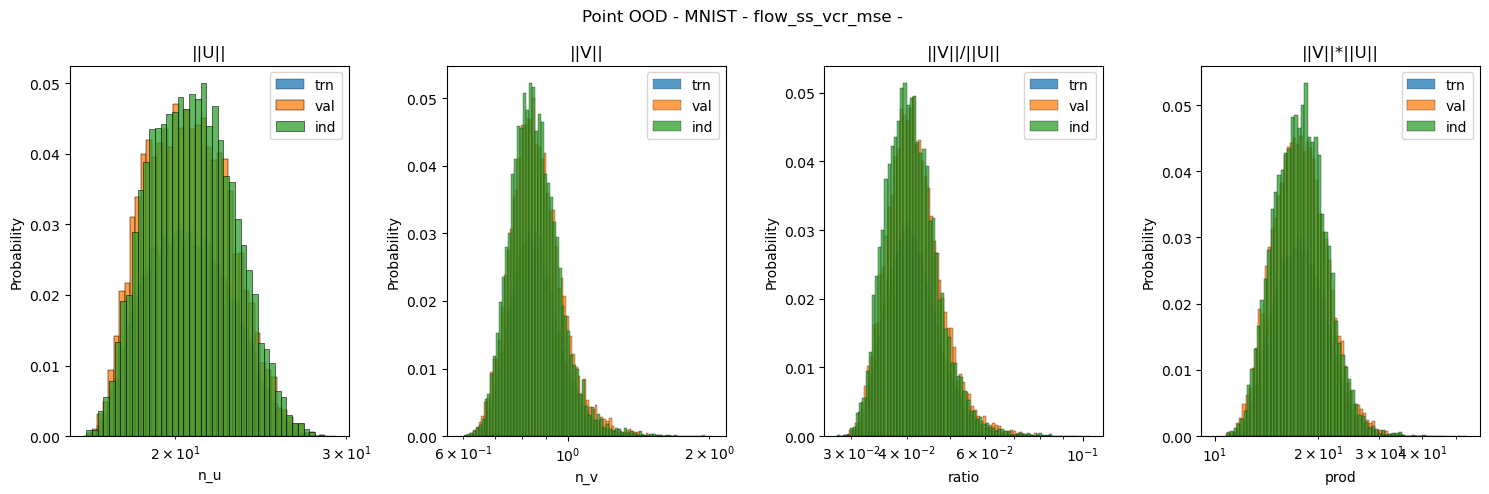

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


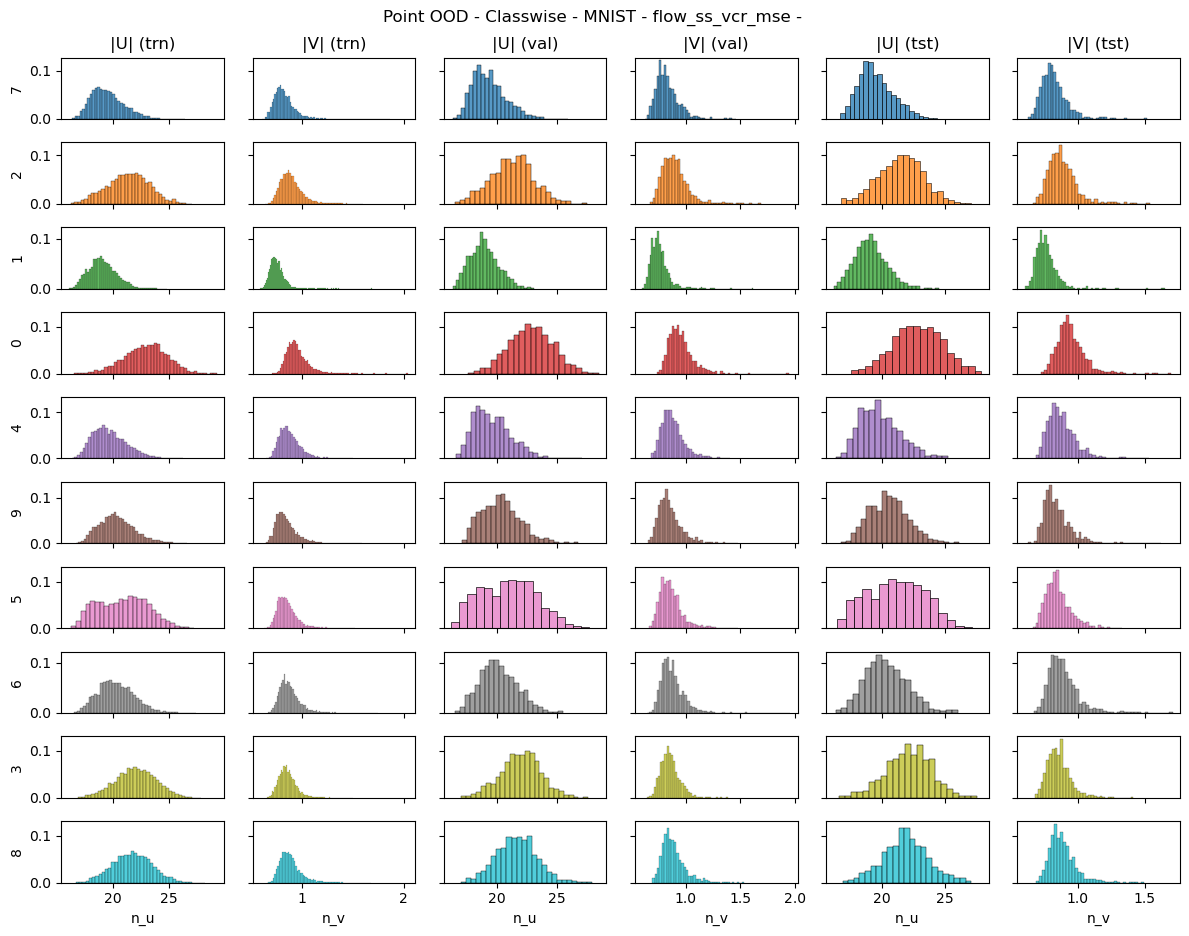

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

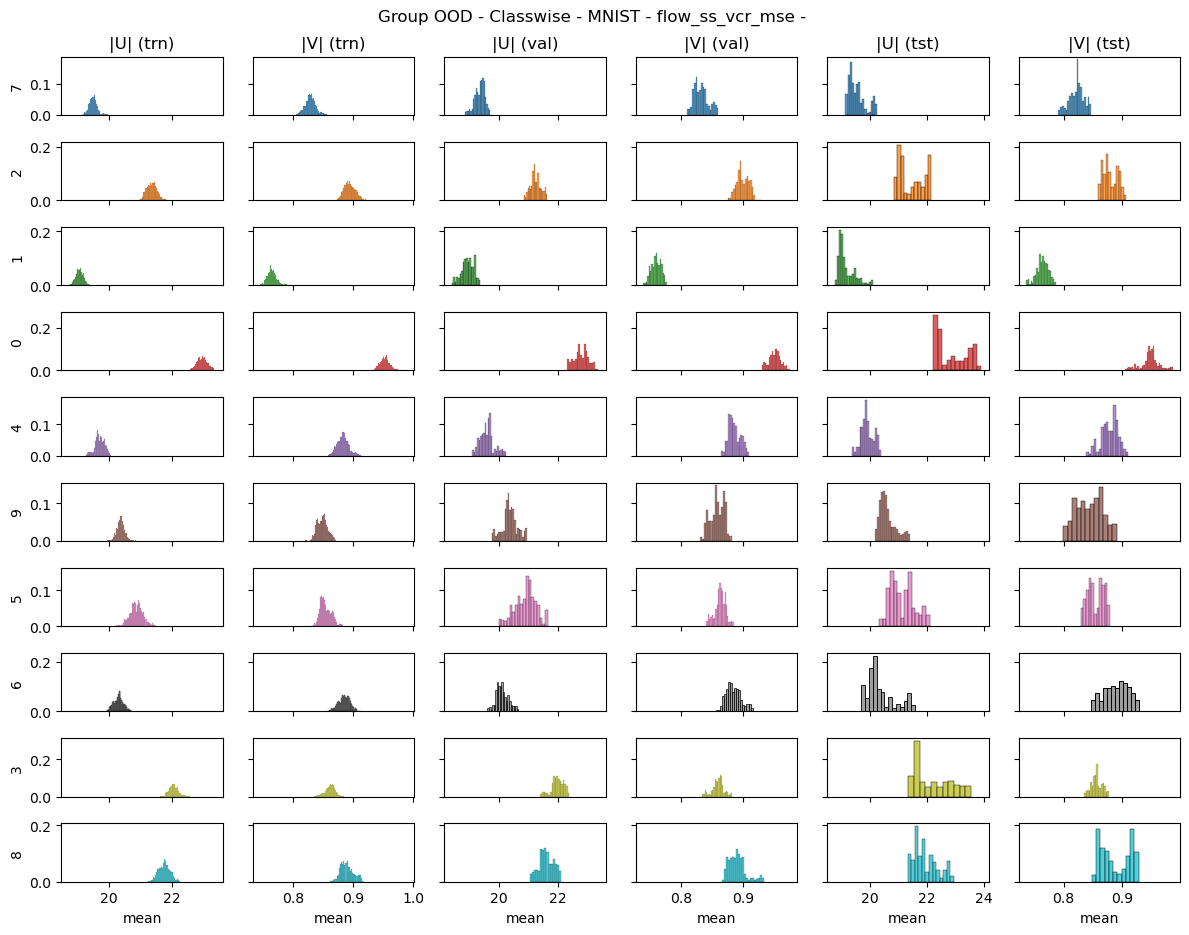

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()